# Graphic Statics II: Hanging Cable 

reference: 
https://block.arch.ethz.ch/eq/course/154/exercise/170

In [4]:
import math as m

import compas
import compas_ags

from compas_ags.diagrams import FormGraph
from compas_ags.diagrams import FormDiagram
from compas_ags.diagrams import ForceDiagram
from compas_ags.ags import graphstatics
from compas_ags.viewers import Viewer

import warnings
warnings.filterwarnings("ignore")

###    create a catenary curve from nodes and edges

In [5]:
### 
###  INPUT HOW MANY LOADS TO ADD
###  INPUT SPAN LENGTH
###  INPUT THE INITIAL TYPE OF CATENARY CURVE
###
loads = 7
length = 10
type = 'arch'
# type = 'hanging_cable'

In [6]:
# create a catenary curve
def catenary_curve(x, type='arch', a=5, xm=0, ym=0):
    if type is 'arch':
        return ym - a * m.cosh((x - xm) / a)
    elif type is 'hanging_cable':
        return ym + a * m.cosh((x - xm) / a)

# create an arch from nodes and edges
nodes = []
edges = []

# add cable lines
for i in range(loads + 2):
    x = i * length / (loads + 1) - length / 2 
    y = catenary_curve(x, type=type)
    nodes.append([x, y, 0])
    if i != loads + 1 : edges.append(tuple([i, i+1])) 
        
loads_uv = []
# add vertical load lines and rection force lines
for i in range(loads + 2):
    if i == 0 or i == loads + 1 :
        x = i * length / (loads + 1) - length / 2 
        y = catenary_curve(x, type=type) - 1.0
        nodes.append([x, y, 0])
    else:
        x = i * length / (loads + 1) - length / 2 
        y = catenary_curve(x, type=type) + 1.0
        nodes.append(([x, y, 0]))
        loads_uv.append(tuple([i, i + loads + 2]))
    edges.append(tuple([i, i + loads + 2]))
        
# add horizontal rection force lines
nodes.append([- length / 2 - 1.0, catenary_curve(-length / 2, type=type), 0])
edges.append(tuple([0, len(nodes) - 1]))

nodes.append([length / 2 + 1.0, catenary_curve(length / 2, type=type), 0])
edges.append(tuple([loads + 1, len(nodes) - 1]))

In [7]:
# make form and force diagrams
graph = FormGraph.from_nodes_and_edges(nodes, edges)
form = FormDiagram.from_graph(graph)
force = ForceDiagram.from_formdiagram(form)

###    prescribe edge force density and set fixed vertices

In [8]:
# prescribe force density to edge
edges_ind = [(0, (loads + 2) * 2)]
f = 5.0
if type == 'arch':
    f *= -1
    
for u, v in edges_ind:
    form.edge_attribute((u, v), 'is_ind', True)
    form.edge_attribute((u, v), 'q', f)

# set the fixed points
left = 0
right = loads + 1
fixed = [left, right]
form.set_fixed(fixed)
force.set_anchor([0])

# update the diagrams
graphstatics.form_update_q_from_qind(form)
graphstatics.force_update_from_form(force, form)

### display force and form diagrams

In [9]:
# store lines representing the current state of equilibrium
form_lines = []
for u, v in form.edges():
    form_lines.append({
        'start': form.vertex_coordinates(u, 'xy'),
        'end'  : form.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

form_lines.append({
        'start': form.vertex_coordinates(0, 'xy'),
        'end'  : form.vertex_coordinates(loads + 1, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

force_lines = []
for u, v in force.edges():
    force_lines.append({
        'start': force.vertex_coordinates(u, 'xy'),
        'end'  : force.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

{(10, 0): 0, (10, 1): 2, (10, 2): 4, (10, 3): 6, (10, 4): 8, (10, 5): 10, (10, 6): 12, (10, 7): 14, (10, 8): 16, (10, 9): 18, (0, 1): 1, (1, 2): 3, (2, 3): 5, (3, 4): 7, (4, 5): 9, (5, 6): 11, (6, 7): 13, (7, 8): 15, (8, 9): 17}


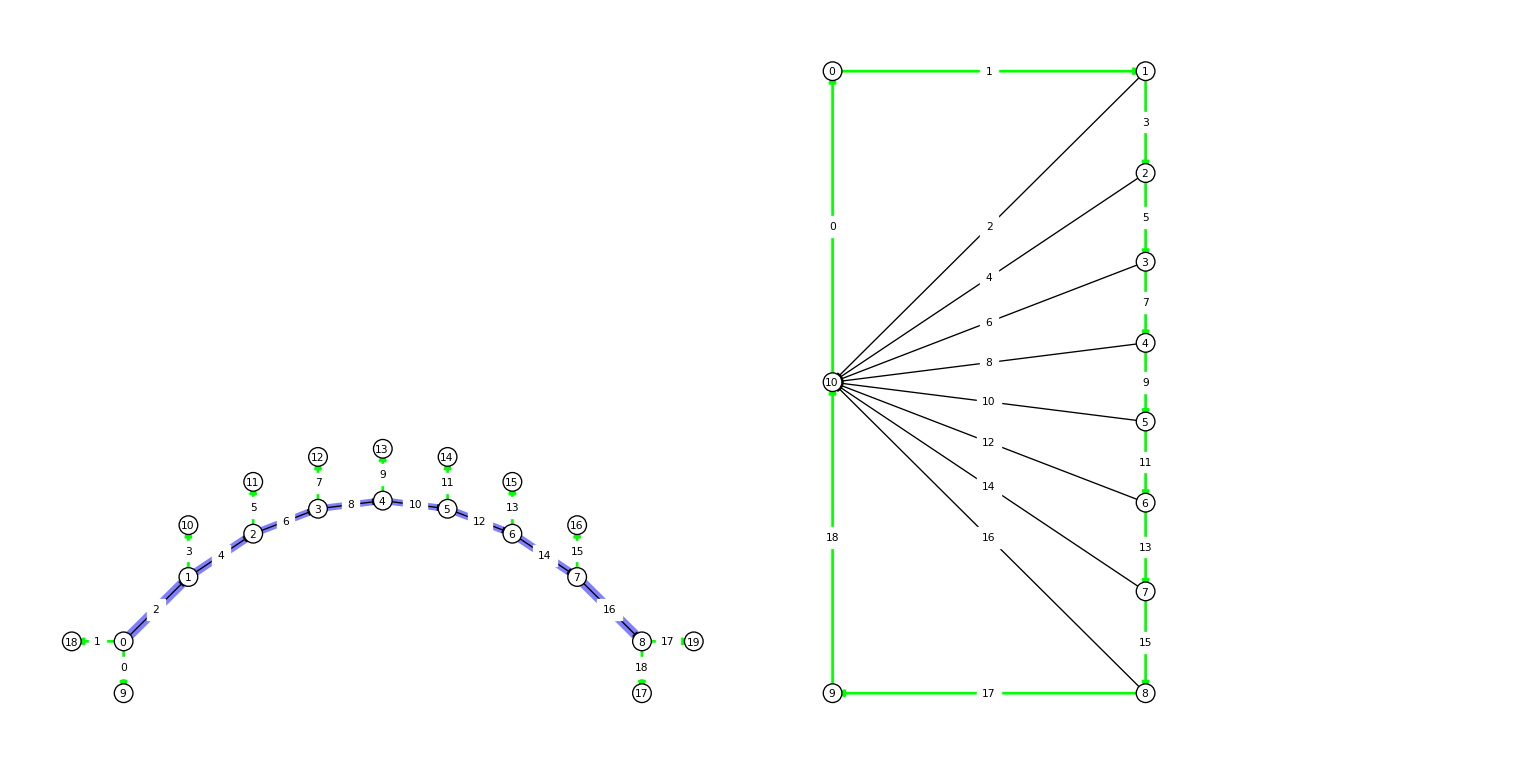

In [10]:
viewer = Viewer(form, force, delay_setup=False)
print(viewer.check_edge_pairs()[1])

viewer.draw_form(
    arrows_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},
    edgelabel={uv: index for index, uv in enumerate(form.edges())},)

    
viewer.draw_force(
    arrows_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()},
    edgelabel=viewer.check_edge_pairs()[1])

viewer.show()

###    force diagram manipulation I: modify cable sag

ATTENTION: THIS PART ONLY WORK WITH AGS2.... 

In [11]:
from compas_ags.ags2.constraints import ConstraintsCollection, HorizontalFix, VerticalFix
import compas_ags.ags2.rootfinding as rf
import numpy as np

# set constraints
C = ConstraintsCollection(form)
C.add_constraint(HorizontalFix(form, left))
C.add_constraint(VerticalFix(form, left))
C.add_constraint(HorizontalFix(form, right))
for i in range(1, loads+1):
    C.add_constraint(HorizontalFix(form, i + loads + 2))
C.constrain_dependent_leaf_edges_lengths()

k_i = form.key_index()
leaves = [k_i[key] for key in form.leaves()]
edges = [(k_i[u], k_i[v]) for u, v in form.edges()]

# modify the geometry of the force diagram and update the form diagram using Newton's method
xy = np.array(form.xy(), dtype=np.float64).reshape((-1, 2))
_xy = np.array(force.xy(), dtype=np.float64).reshape((-1, 2))

# find vertices in the force diagram and move them to the right
# which means making the internal forces and boundary forces smaller
_x_min = min(_xy[:,0])
move_vertices = []
for i, v in enumerate(_xy):
    if v[0] > (_x_min-.1) and v[0] < (_x_min+.1):
        move_vertices.append(i)

### 
###  INPUT DISTANCE TO MOVE IN X DIRECTION
###
_xy[move_vertices, 0] += 1.0

# compute the form diagram
_X_goal = np.vstack((np.asmatrix(_xy[:, 0]).transpose(), np.asmatrix(_xy[:, 1]).transpose()))
rf.compute_form_from_force_newton(form, force, _X_goal, constraints=C)

i: 1 diff: 2.83e+00
i: 2 diff: 8.01e-01
i: 3 diff: 3.57e-14
Converged in 4 iterations


###    update force and form diagrams

In [12]:
constraint_lines = C.get_lines()
form_lines = form_lines + constraint_lines

form_lines.append({
        'start': form.vertex_coordinates(0, 'xy'),
        'end'  : form.vertex_coordinates(loads + 1, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

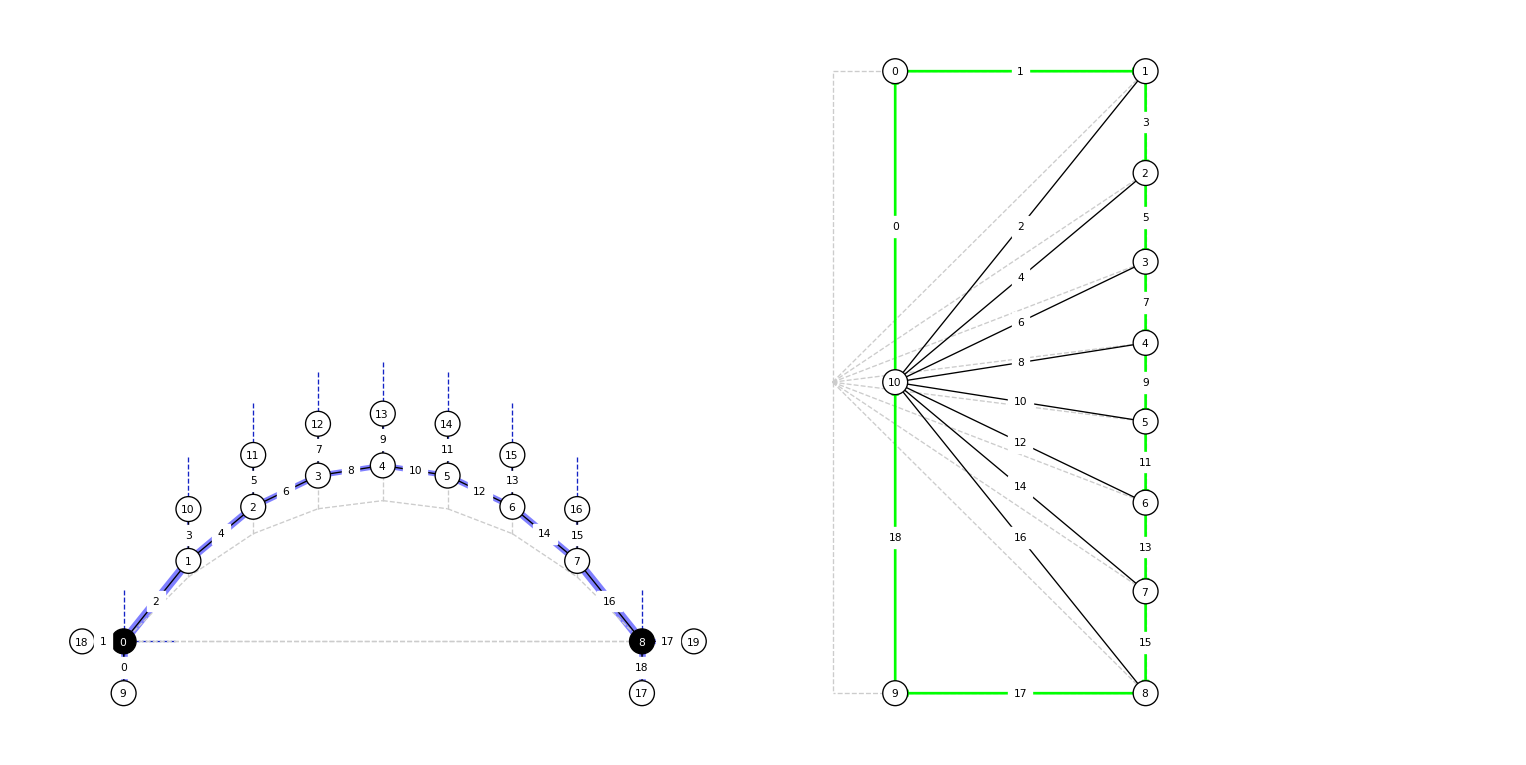

In [13]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(lines=form_lines,
                 forces_on=True,
                 vertexlabel={key: key for key in form.vertices()},
                 external_on=False,
                 vertexsize=0.2,
                 vertexcolor={key: '#000000' for key in fixed},
                 edgelabel={uv: index for index, uv in enumerate(form.edges())}
)

viewer.draw_force(lines=force_lines,
                  vertexlabel={key: key for key in force.vertices()},
                  vertexsize=0.2,
                  edgelabel=viewer.check_edge_pairs()[1]
)

viewer.show()

###    force diagram manipulation II

In [14]:
# store lines representing the current state of equilibrium
form_lines = []
for u, v in form.edges():
    form_lines.append({
        'start': form.vertex_coordinates(u, 'xy'),
        'end'  : form.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

form_lines.append({
        'start': form.vertex_coordinates(0, 'xy'),
        'end'  : form.vertex_coordinates(loads + 1, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

force_lines = []
for u, v in force.edges():
    force_lines.append({
        'start': force.vertex_coordinates(u, 'xy'),
        'end'  : force.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

In [15]:
### 
###  INPUT VERTEX KEY IN FORCE DIAGRAM TO MOVE
###
vkey_to_move = 10

In [16]:
from compas_ags.ags2.constraints import ConstraintsCollection, HorizontalFix, VerticalFix
import compas_ags.ags2.rootfinding as rf
import numpy as np

# set constraints
# find vertices in the force diagram and move them to the right
# which means making the internal forces and boundary forces smaller
C = ConstraintsCollection(form)
C.add_constraint(HorizontalFix(form, left))
C.add_constraint(VerticalFix(form, left))
C.add_constraint(HorizontalFix(form, right))
for i in range(1, loads+1):
    C.add_constraint(HorizontalFix(form, i + loads + 2))
C.constrain_dependent_leaf_edges_lengths()

# modify the geometry of the force diagram and update the form diagram using Newton's method
xy = np.array(form.xy(), dtype=np.float64).reshape((-1, 2))
_xy = np.array(force.xy(), dtype=np.float64).reshape((-1, 2))


### 
###  INPUT DISTANCE AND DIRECTION TO MOVE
###
_xy[force.key_index()[vkey_to_move], 1] += 1.0

# compute the form diagram
_X_goal = np.vstack((np.asmatrix(_xy[:, 0]).transpose(), np.asmatrix(_xy[:, 1]).transpose()))
rf.compute_form_from_force_newton(form, force, _X_goal, constraints=C)

i: 1 diff: 1.00e+00
i: 2 diff: 4.64e-14
Converged in 3 iterations


###    update force and form diagrams

In [17]:
constraint_lines = C.get_lines()
form_lines = form_lines + constraint_lines

form_lines.append({
        'start': form.vertex_coordinates(0, 'xy'),
        'end'  : form.vertex_coordinates(loads + 1, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

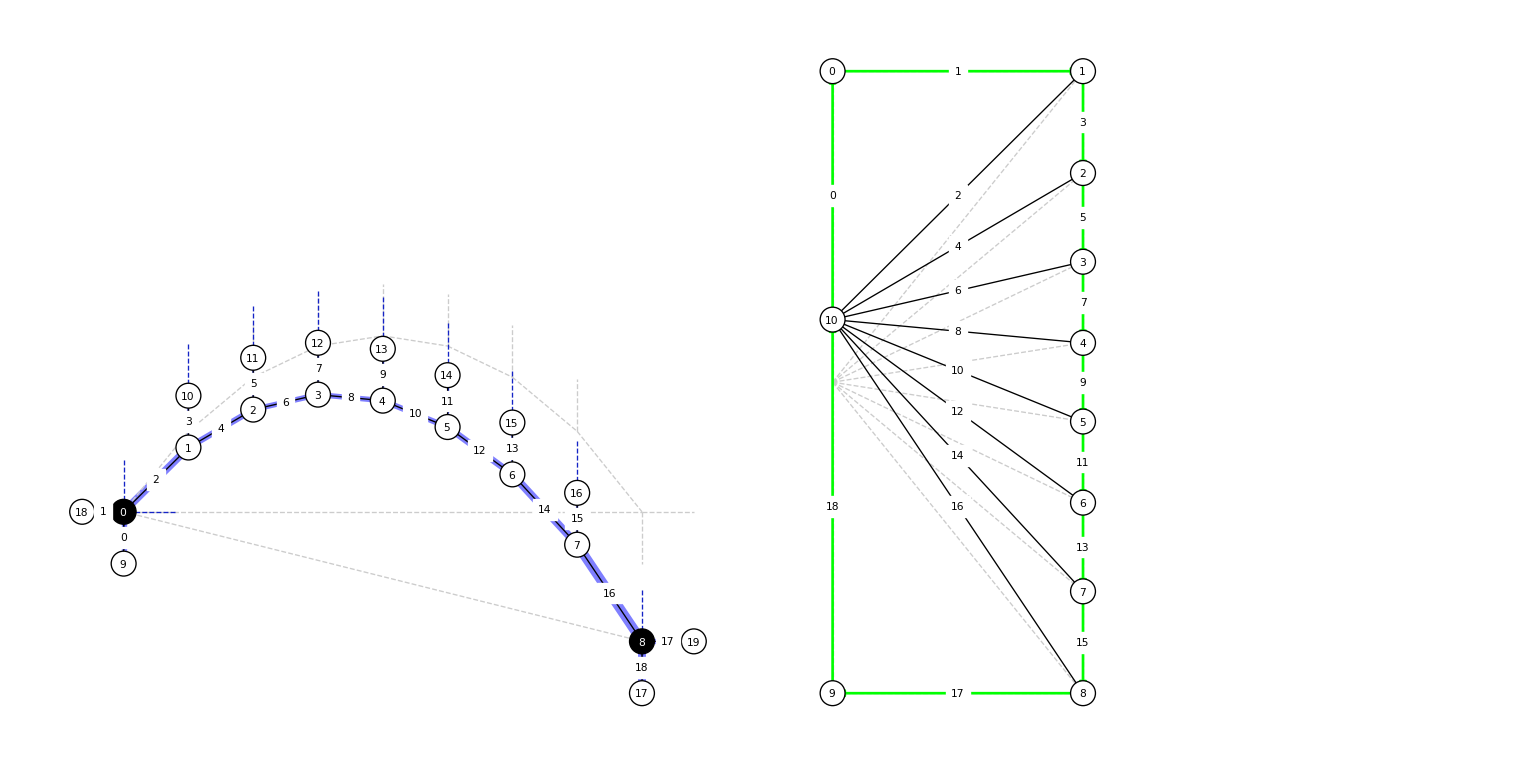

In [18]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(lines=form_lines,
                 forces_on=True,
                 vertexlabel={key: key for key in form.vertices()},
                 external_on=False,
                 vertexsize=0.2,
                 vertexcolor={key: '#000000' for key in fixed},
                 edgelabel={uv: index for index, uv in enumerate(form.edges())}
)

viewer.draw_force(lines=force_lines,
                  vertexlabel={key: key for key in force.vertices()},
                  vertexsize=0.2,
                  edgelabel=viewer.check_edge_pairs()[1]
)

viewer.show()